In [ ]:
# GIẢI PHÁP
Trước đây, khi chưa biết đến mã hóa, nhiều anh em thường **lưu mật khẩu** người dùng dưới dạng **Plain Text** (văn bản thuần túy) vào Database.
> **Hệ quả**: Nếu chẳng may Database bị rò rỉ (do bị hack hoặc sơ suất), hacker sẽ nhìn thấy toàn bộ mật khẩu của người dùng. Tệ hơn, người dùng thường có thói quen dùng chung 1 mật khẩu cho nhiều tài khoản (Facebook, Gmail, Ngân hàng...), dẫn đến thiệt hại dây chuyền cực kỳ nghiêm trọng.

In [ ]:
# GIẢI PHÁP
- Chúng ta cần một "máy nghiền" mật khẩu. 
- Thay vì lưu mật khẩu thật, ta chỉ lưu "dấu vân tay" của mật khẩu đó. 
- Khi người dùng đăng nhập, ta lại mang mật khẩu họ vừa nhập vào "máy nghiền" đó, nếu kết quả ra đúng "dấu vân tay" đã lưu thì cho phép vào.
> Cái "máy nghiền" này chính là Mã hóa một chiều (One-way Hashing).

In [ ]:
# Khái niệm & Tại sao (ELI5)
- Nó giống như việc em làm sinh tố bơ vậy. 
- Từ quả bơ, em xay ra cốc sinh tố. 
- Nhưng đố em từ cốc sinh tố đó mà biến ngược lại thành quả bơ nguyên vẹn được đấy? Không bao giờ!

In [ ]:
# So sánh MD5/SHA1 với Bcrypt:
- **MD5 & SHA1 (Những chiếc máy xay đời cũ)**: 
	+ Tốc độ xay cực nhanh. 
	+ Nhưng vì nó quá nhanh, hacker có thể dùng những dàn máy tính khủng để thử hàng tỷ khả năng mỗi giây (Brute-force) hoặc dùng các bảng tra cứu sẵn (Rainbow Tables) để tìm lại mật khẩu gốc. 
> Hiện nay, chúng được coi là **không còn an toàn để lưu mật khẩu.**

---

- **Bcrypt (Chiếc máy xay bọc thép)**: Sinh ra để khắc phục điểm yếu của MD5/SHA1. Nó **chậm một cách cố ý** và có cơ chế **tự động thêm muối** (Salt).

In [ ]:
# Brute force (tấn công vét cạn) 
- Là phương pháp thử và sai (trial-and-error) tự động, trong đó tin tặc liên tục nhập hàng loạt mật khẩu, tên người dùng hoặc khóa mã hóa cho đến khi tìm ra thông tin đăng nhập đúng để truy cập trái phép vào hệ thống. Dù đơn giản, kỹ thuật này rất phổ biến vì hiệu quả đối với tài khoản yếu. 

## Đặc điểm chính của Brute Force Attack:
- **Nguyên lý**: Thử mọi tổ hợp có thể (ví dụ: aaaa, aaab, aaac...).
- **Mục đích**: Đánh cắp thông tin, chiếm quyền điều khiển tài khoản, hệ thống quản trị, hoặc email.
- **Thời gian**: Có thể kéo dài từ vài giây đến nhiều năm, tùy thuộc vào độ phức tạp của mật khẩu. 

In [ ]:
# Cách hoạt động bên trong của Bcrypt
- Bcrypt không chỉ là một thuật toán băm đơn thuần, nó hoạt động dựa trên 3 thành phần cốt lõi:
1. **Salt (Muối)**: Đây là một chuỗi ngẫu nhiên được tự động tạo ra và cộng thêm vào mật khẩu trước khi băm. 
- Điều này giúp cho 2 người dùng dù có cùng mật khẩu `123456` thì mã hash lưu trong DB vẫn hoàn toàn khác nhau. Hacker không thể dùng bảng tra cứu sẵn được nữa.

2. **Cost Factor (Độ phức tạp)**: Đây là một con số (thường là 10-12). Nó quyết định số vòng lặp mà thuật toán phải thực hiện. Con số này càng cao, thời gian băm càng lâu.

3. **Hasing**: Cuối cùng mới thực hiện băm để tạo ra chuỗi mã hóa.



In [ ]:
// src/utils/password.helper.js
const bcrypt = require("bcrypt");

/**
 * Mã hóa mật khẩu người dùng
 * @param {string} password - Mật khẩu thuần
 * @returns {Promise<string>} - Chuỗi mật khẩu đã được hash
 */
const hashPassword = async (password) => {
    // Cost factor = 10 (mức độ cân bằng giữa bảo mật và hiệu năng)
    const saltRounds = 10; 
    
    // Tự động tạo Salt và thực hiện Hash
    return await bcrypt.hash(password, saltRounds);
};

/**
 * Kiểm tra mật khẩu người dùng nhập vào
 * @param {string} password - Mật khẩu thuần từ Client
 * @param {string} hashedPassword - Chuỗi hash đã lưu trong DB
 * @returns {Promise<boolean>} - Trả về true nếu khớp
 */
const comparePassword = async (password, hashedPassword) => {
    // Bcrypt tự tách Salt từ hashedPassword để so sánh, mình không cần lo
    return await bcrypt.compare(password, hashedPassword);
};

module.exports = { hashPassword, comparePassword };

In [ ]:
// user.controller.js

const jwt = require("jsonwebtoken");
const crypto = require("crypto");
const bcrypt = require("bcrypt");
const { secret } = require("@/config/jwt");
const postModel = require("@/models/post.model");
const userModel = require("@/models/user.model");
const postService = require("@/services/post.service");

/* Base 64 an toàn */
function base64Encode(string) {
    return btoa(string)
        .replace(/\+/g, "-") // Replace '+' with '-'
        .replace(/\//g, "_") // Replace '/' with '_'
        .replace(/=+$/, ""); // Remove trailing '=' padding
}

/**
 * Mã hóa mật khẩu người dùng
 * @param {string} password - Mật khẩu thuần
 * @returns {Promise<string>} - Chuỗi mật khẩu đã được hash
 */
const hashPassword = async (password) => {
    // Cost factor = 10 (mức độ cân bằng giữa bảo mật và hiệu năng)
    const saltRounds = 10;

    // Tự động tạo Salt và thực hiện Hash
    return await bcrypt.hash(password, saltRounds);
};

/**
 * Kiểm tra mật khẩu người dùng nhập vào
 * @param {string} password - Mật khẩu thuần từ Client
 * @param {string} hashedPassword - Chuỗi hash đã lưu trong DB
 * @returns {Promise<boolean>} - Trả về true nếu khớp
 */
const comparePassword = async (password, hashedPassword) => {
    // Bcrypt tự tách Salt từ hashedPassword để so sánh, mình không cần lo
    return await bcrypt.compare(password, hashedPassword);
};

module.exports = { hashPassword, comparePassword };

/* Đăng ký */
const register = async (req, res) => {
    // Chỉ lấy những trường chúng ta cần từ request
    const { email, password } = req.body;

    // Tạo chuỗi hash bằng Bcrypt
    const hash = await hashPassword(password);

    const insertId = await userModel.create(email, hash);
    const newUser = {
        id: insertId,
        email,
    };
    res.success(newUser, 201);
};

/* Đăng nhập */
const login = async (req, res) => {
    const { email, password } = req.body;
    const user = await userModel.findByEmail(email);

    if (!user) {
        return res.error("Unauthorized", 401);
    }

    // Kiểm tra mật khẩu hợp lệ
    const isValid = await comparePassword(password, user.password);
    if (!isValid) {
        return res.error("Unauthorized", 401);
    }

    /* 
    - btoa(): Encoded - Mã hoá Base64
    - atob(): Decoded - Giải mã Base 64
    */
    // todo: Tự Ký token thủ công
    // Header --> base64 Encoded
    const header = base64Encode(
        JSON.stringify({
            alg: "HS256",
            typ: "JWT",
        }),
    );

    // Payload --> base64 Encoded
    const payload = base64Encode(
        JSON.stringify({
            sub: user.id,
            exp: Date.now() + 60 * 60 * 1000,
        }),
    );

    // Signature - Thuật toán HMAC256
    const hmac = crypto.createHmac("sha256", secret);
    hmac.update(`${header}.${payload}`); // tham số: chuỗi base 64 của header nối với payload
    const signature = hmac.digest("base64url"); // Đây chính là chữ ký được chuyển đổi sang base64 an toàn

    const token = `${header}.${payload}.${signature}`;

    res.success(user, 200, {
        access_token: token,
        access_token_ttl: 3600,
    });
};

/* Lấy ra người dùng hiện tại */
const getCurrentUser = async (req, res) => {
    res.success(req.user);
};

module.exports = { register, login, getCurrentUser };


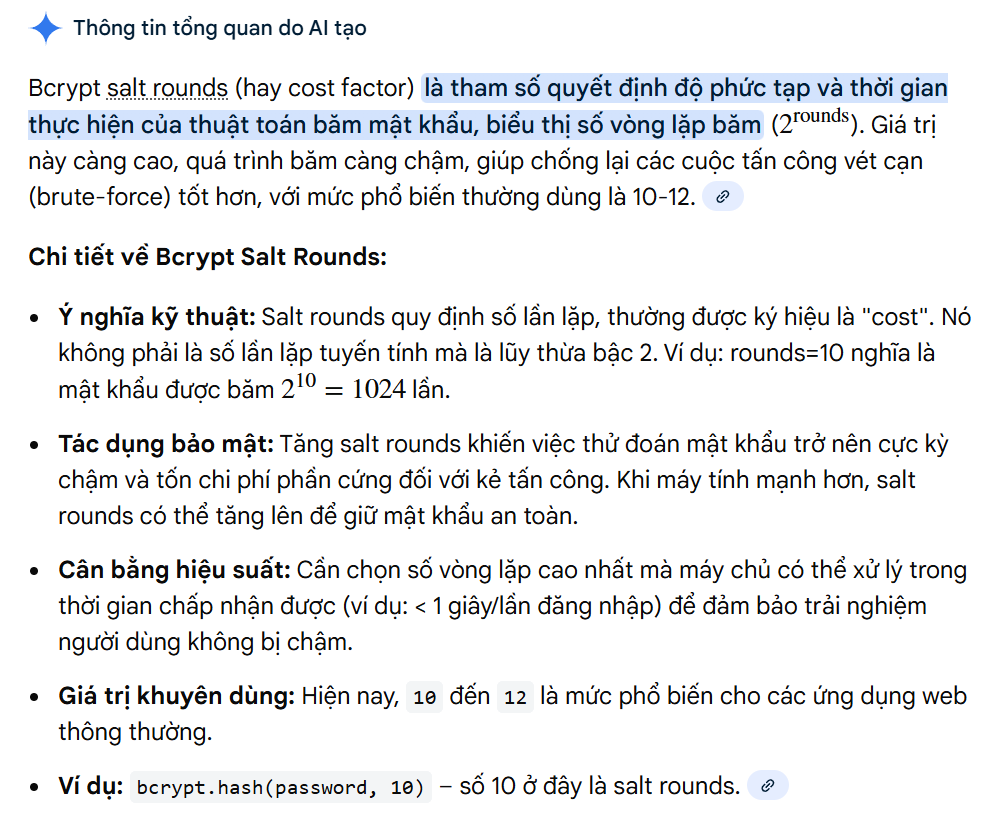

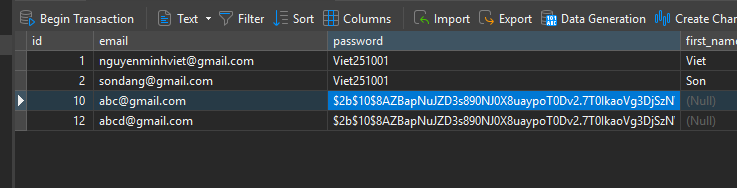

In [ ]:
Câu hỏi: Nếu Copy mật khẩu từ user12 lên user10 thì user10 có đăng nhập được với mật khẩu gốc là (`1234567`) không?
> Có: Vì việc khi tạo ra password thì không có sự tham gia của email, nên không bị phụ thuộc vào email

> Giả sử trong tương lai mà chúng ta bị quên mật khẩu của account bất kỳ, chúng ta không thể cầm mật khẩu gốc mà sửa lại trong field password trong DB (VD: admin 123)

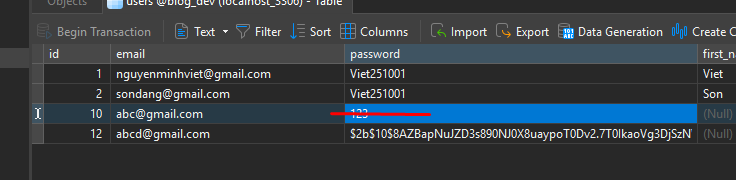

In [ ]:
# Giải pháp:
Chúng ta lên Bcrypt: Nhập input là mật khẩu bất kỳ (mà ta mong muốn, ví dụ: xyz123). Sau đó chúng ta hash. Cầm chuỗi đó nhập lại vào field DB. Vậy là chúng ta đã có mật khẩu mới

In [ ]:
## TUYỆT ĐỐI
- Bài trừ các lưu mật khẩu dưới dạng Plain Text (mật khẩu gốc)
- Lưu Plain Text là đi tù